In [42]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [43]:
seed = 42  # set random seed
np.random.seed(seed)
sampling = int(1e5)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [44]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [45]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(
    processor.process_dipart(data.LepP, data.LepM)[["E", "pz"]][cut_pre]
)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (47089, 10)
      MET_px     MET_py           E        px         py         pz  \
2  16.800106 -30.457136   27.938791  4.063994  13.764582 -95.239852   
3 -24.448158 -12.000150   39.585180  7.269995  81.570773  35.825145   
4 -41.983970 -15.922710  196.946359  8.435738  -2.516708 -76.383867   

            E         px         py          pz  
2   81.878680 -67.647688  34.348543  -80.730063  
3   38.543746  24.098484   7.282697  376.069875  
4  585.067500  36.725297  18.096498  -68.565711  

dinu_kin shape: (47089, 2)
            E          pz
2  109.817471 -175.969914
3   78.128926  411.895020
4  782.013859 -144.949578



30964

In [46]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, sampling)
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=seed, shuffle=True
)

train_x = dinu_kin[train_indices]
valid_x = dinu_kin[valid_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (40000, 2);
Validing data shape: (30000, 2);
Testing data shape: (30000, 2).
Y (Observed)
Training data shape: (40000, 10);
Validing data shape: (30000, 10);
Testing data shape: (30000, 10).



In [47]:
def build_model():
    model = keras.models.Sequential()

    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.Dense(units=8, activation="relu"))
    # model.add(layers.BatchNormalization())
    # model.add(layers.ReLU())
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.Dense(units=4, activation="relu"))
    # model.add(layers.BatchNormalization())
    # model.add(layers.ReLU())

    # Last dense layers
    model.add(layers.Dense(units=2, activation="linear"))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["accuracy"],
    )

    return model

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.0026516143698245287; accuracy of 98.92571568489075%
Plotting fold 1 loss history...


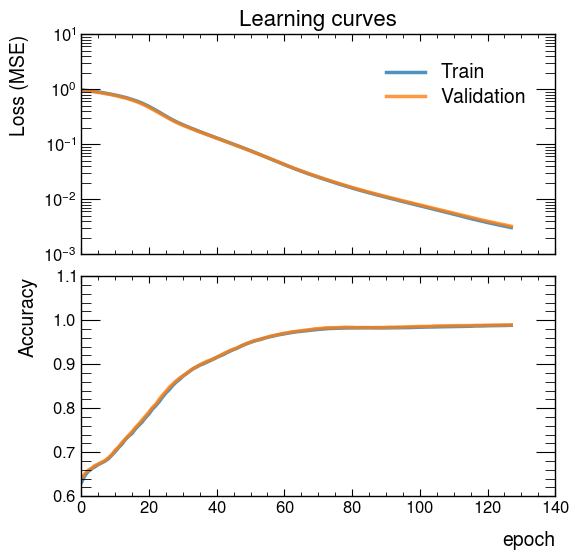

------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.007923821918666363; accuracy of 98.19428324699402%
Plotting fold 2 loss history...


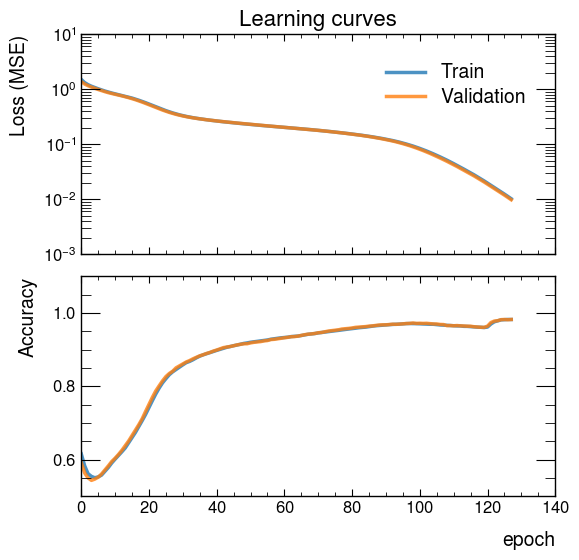

------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.0035856845788657665; accuracy of 98.99428486824036%
Plotting fold 3 loss history...


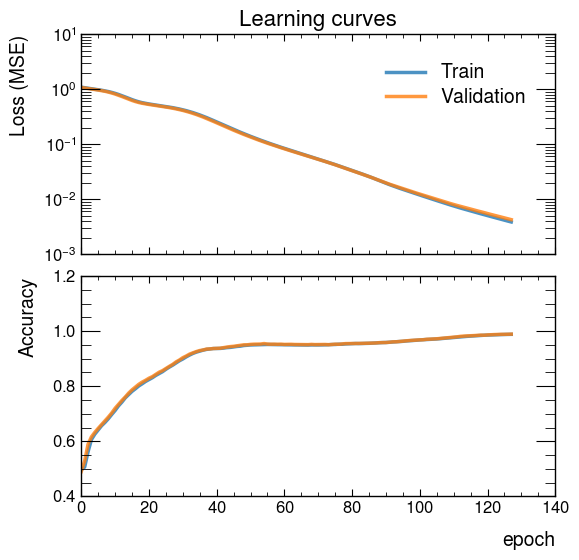

------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.00015185834490694106; accuracy of 99.76000189781189%
Plotting fold 4 loss history...


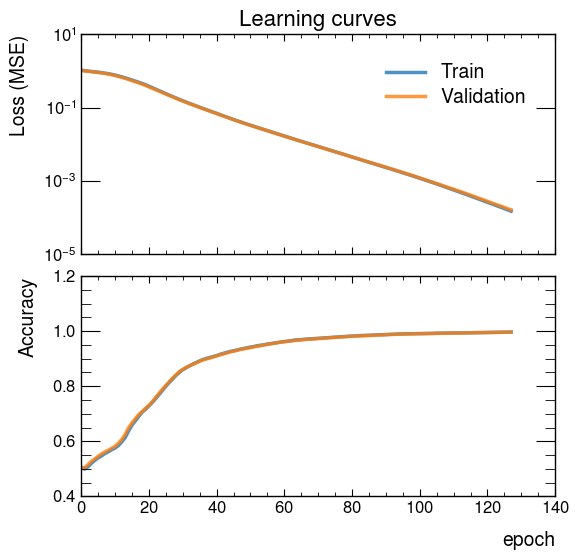

------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.0018588193925097585; accuracy of 98.64000082015991%
Plotting fold 5 loss history...


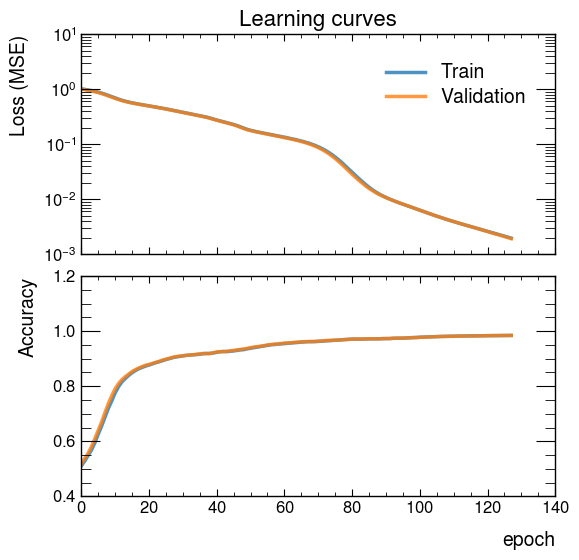

------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.11204176396131516; accuracy of 99.63428378105164%
Plotting fold 6 loss history...


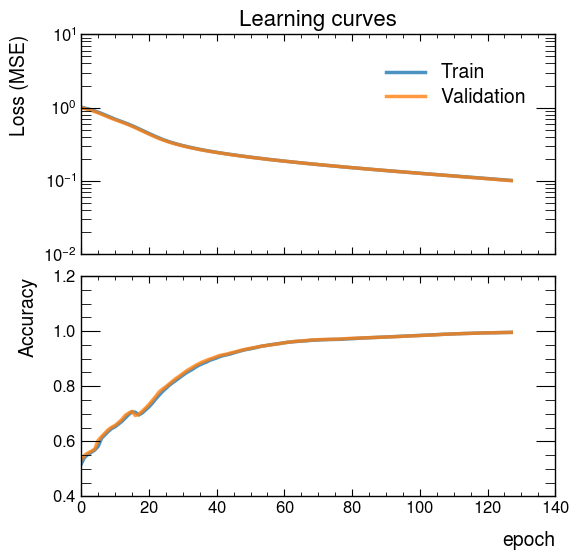

------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 0.00214600027538836; accuracy of 98.64000082015991%
Plotting fold 7 loss history...


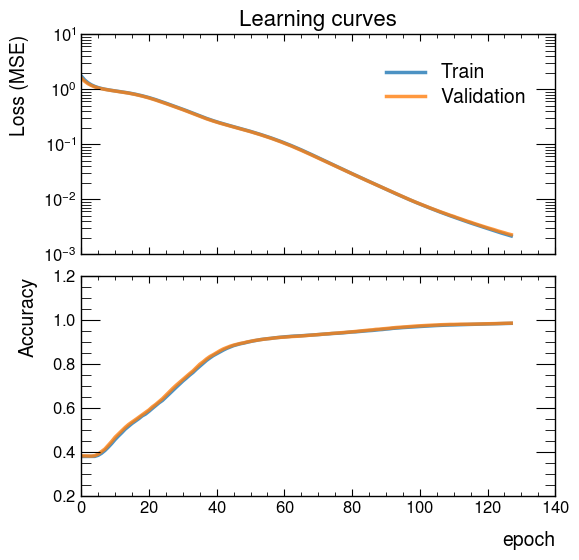

------------------------------------------------------------------------
Training for fold 8 ...
Score for fold 8: loss of 0.0015790974721312523; accuracy of 99.3485689163208%
Plotting fold 8 loss history...


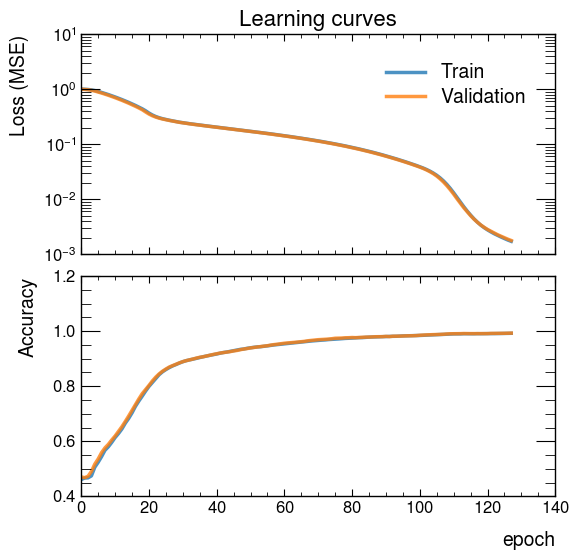

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 10)                0         
                                                                 
 dense_105 (Dense)           (None, 8)                 88        
                                                                 
 dense_106 (Dense)           (None, 8)                 72        
                                                                 
 dense_107 (Dense)           (None, 4)                 36        
                                                                 
 dense_108 (Dense)           (None, 4)                 20        
                                                                 
 dense_109 (Dense)           (None, 2)                 10        
                                                                 
Total params: 226 (904.00 Byte)
Trainable params: 226

In [48]:
from sklearn.model_selection import KFold

num_folds = 8

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((train_y, test_y), axis=0)
targets = np.concatenate((train_x, test_x), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
best_model = None
best_loss = np.inf

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

for train, test in kfold.split(inputs, targets):
    # Define the model architecture
    model = build_model()

    # Generate a print
    print("------------------------------------------------------------------------")
    print(f"Training for fold {fold_no} ...")

    # Fit the model
    history = model.fit(
        x=train_y,
        y=train_x,
        validation_data=(valid_y, valid_x),
        epochs=128,
        batch_size=512,
        verbose=0,
        callbacks=[stop_early],
    )

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(
        f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%"
    )
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Check if this model is better than the previous best model
    if scores[0] < best_loss:
        best_loss = scores[0]
        best_model = model

    # Plotting training results
    plot = ap.Plotter()
    print(f"Plotting fold {fold_no} loss history...")
    plot.plot_loss_history(history, logy=True)
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
best_model.summary()
print("------------------------------------------------------------------------")
print("Score per fold")
for i in range(0, len(acc_per_fold)):
    print("------------------------------------------------------------------------")
    print(f"> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%")
print("------------------------------------------------------------------------")
print("Average scores for all folds:")
print(f"> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})")
print(f"> Loss: {np.mean(loss_per_fold)}")
print("------------------------------------------------------------------------")

In [49]:
# save model
best_model.save("AE_miss.h5", save_format="h5", overwrite=True)
# predict
x_pred = best_model.predict(test_y)
sig_pred = x_pred
sig_truth = test_x

  1/938 [..............................] - ETA: 58s

 35/938 [>.............................] - ETA: 1s 

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


938/938 [==============================] - 1s 1ms/step


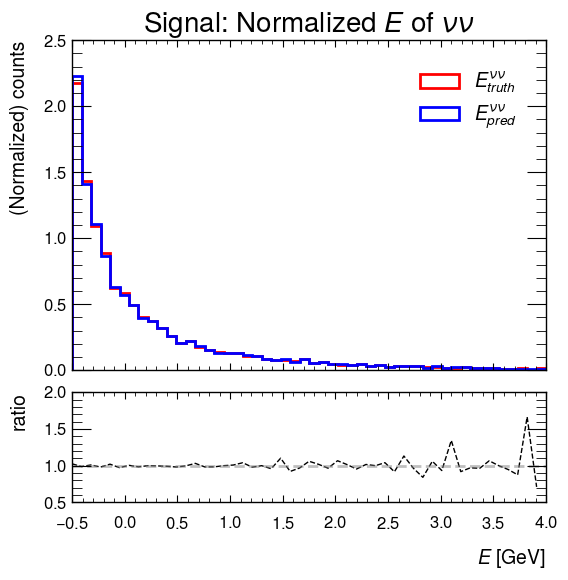

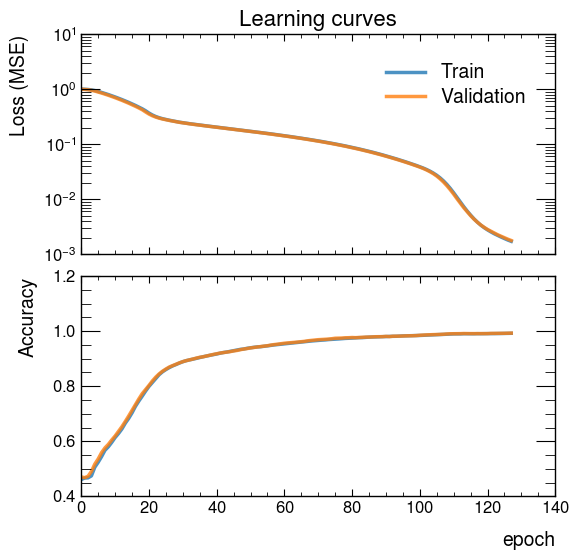

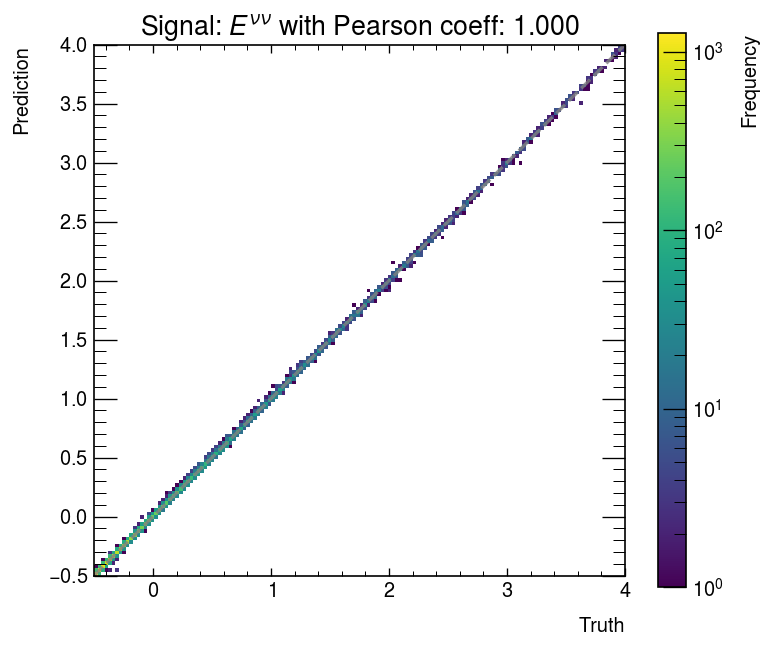

In [50]:
import scipy as sp

plot = ap.Plotter()

range = [-0.5, 4]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Signal: Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_loss_history(history, logy=True)

plot.plot_2d_histogram(
    sig_pred[:, 0],
    sig_truth[:, 0],
    "Signal: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)

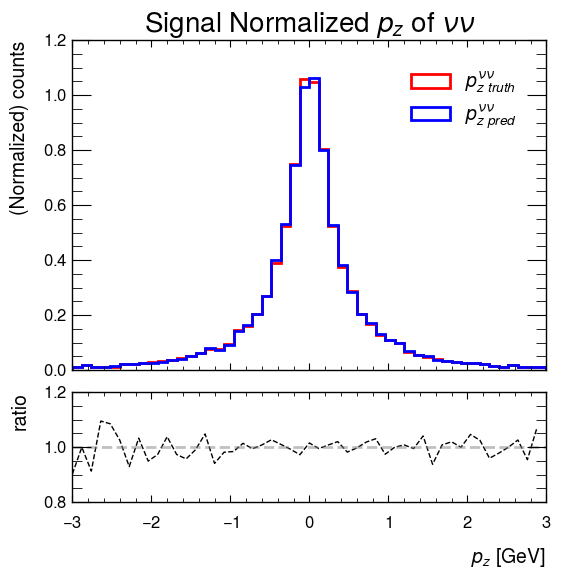

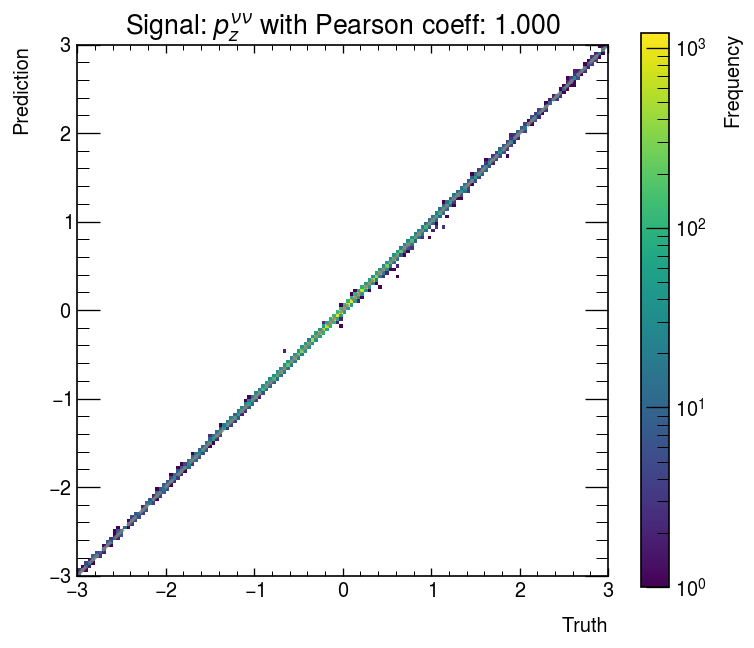

In [51]:
range = [-3, 3]

plot.plot_hist(
    [sig_truth[:, 1], sig_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Signal Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    sig_truth[:, 1],
    sig_pred[:, 1],
    r"Signal: $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
    range=range,
)

In [52]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/work/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/work/truth/background/CGLMP.npz', '/root/work/truth/background/Higgs.npz', '/root/work/truth/background/LeadLepton.npz', '/root/work/truth/background/LeptonM.npz', '/root/work/truth/background/LeptonP.npz', '/root/work/truth/background/LmNu.npz', '/root/work/truth/background/LpNu.npz', '/root/work/truth/background/MET.npz', '/root/work/truth/background/WmBoson.npz', '/root/work/truth/background/WpBoson.npz', '/root/work/truth/background/diLepton.npz', '/root/work/truth/background/subLeadLepton.npz', '/root/work/truth/background/xi_xyz.npz']



In [53]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(
    processor.process_dipart(data.LepP, data.LepM)[["E", "pz"]][cut_pre]
)
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (47089, 10)
      MET_px     MET_py          E         px         py         pz  \
2  12.542417  29.573581  47.815059 -21.315428  45.633828  -9.166943   
3 -28.046018 -45.255130  43.335184  30.948270 -12.014405 -59.042395   
4  -6.118746 -43.808047  31.977082  41.501539 -72.848164  65.469578   

            E         px         py          pz  
2   17.210883  20.278842  -5.134687   48.637703  
3  181.251000  -5.289632  10.576978 -406.692406  
4   30.541406 -21.632902 -12.714723  -71.628742  

dinu_kin shape: (47089, 2)
            E          pz
2   65.025941   39.470760
3  224.586184 -465.734801
4   62.518488   -6.159164



129392

In [54]:
SCALAR_int_bkg = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET_bkg = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

x, y = dinu_kin[indices_arr], MET_kin[indices_arr]

print(f"X (Interest) data shape: {x.shape};\nY (Observed) data shape: {y.shape}.")
print()

X (Interest) data shape: (100000, 2);
Y (Observed) data shape: (100000, 10).



In [55]:
x_pred = best_model.predict(y)
bkg_pred = x_pred
bkg_truth = x

3125/3125 [==============================] - 4s 1ms/step


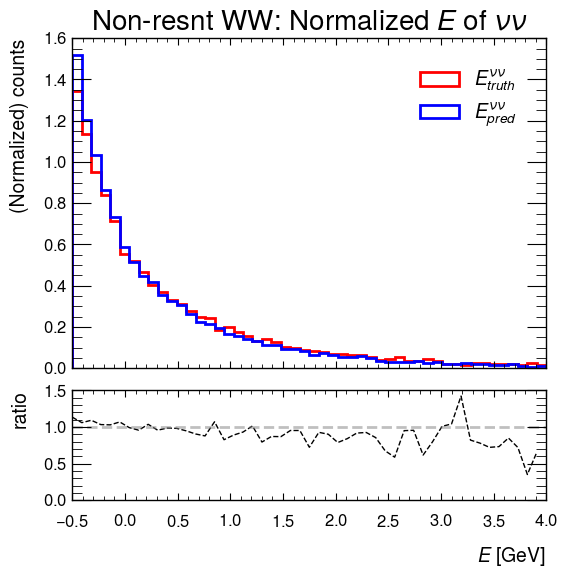

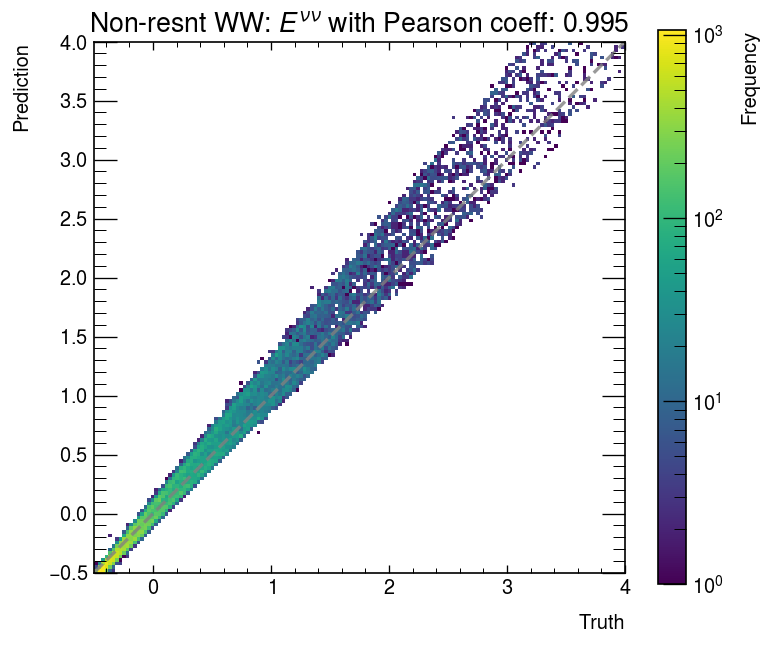

In [56]:
plot = ap.Plotter()

range = [-0.5, 4]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

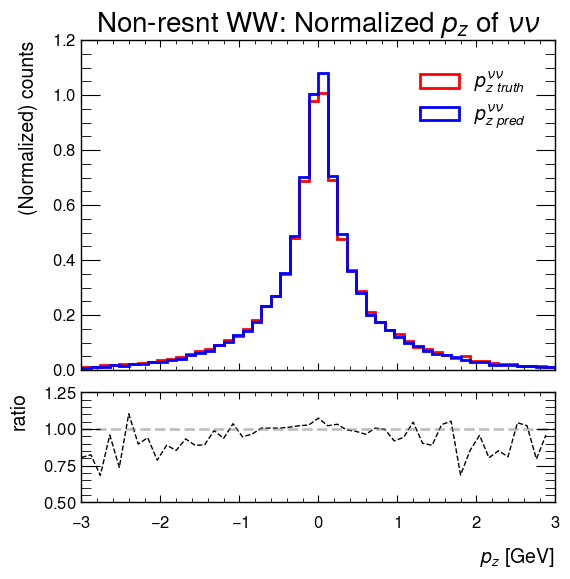

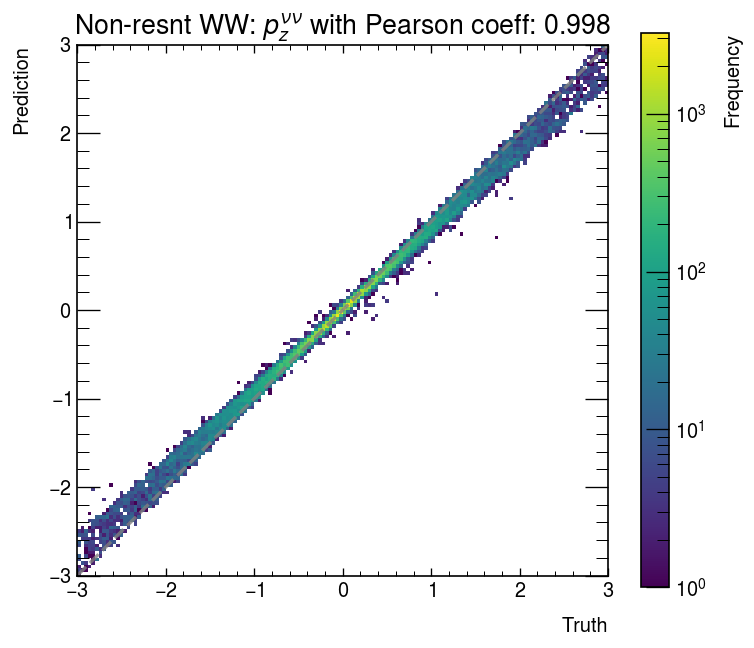

Time cost: 459.26 s.


In [57]:
range = [-3, 3]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")